In [94]:
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
import pandas as pd

### Chargez les données

In [12]:
data = pd.read_csv("PJM_Load_hourly.csv", index_col="Datetime", parse_dates=True)
data.head()

,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0


In [20]:
data.tail()

,PJM_Load_MW
Datetime,
2001-01-01 20:00:00,35209.0
2001-01-01 21:00:00,34791.0
2001-01-01 22:00:00,33669.0
2001-01-01 23:00:00,31809.0
2001-01-02 00:00:00,29506.0


<Axes: xlabel='Datetime'>

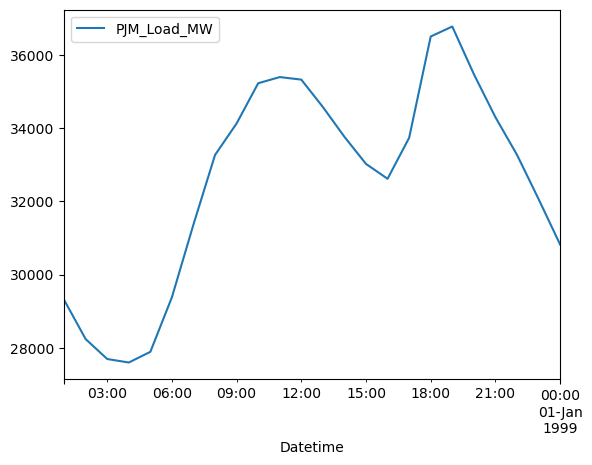

In [18]:
data.iloc[:24].plot()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-12-31 01:00:00 to 2001-01-02 00:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1)
memory usage: 514.0 KB


In [25]:
data.describe()

,PJM_Load_MW
count,32896.000000
mean,29766.427408
std,5849.769954
min,17461.000000
25%,25473.000000
50%,29655.000000
75%,33073.250000
max,54030.000000


In [58]:
data["Days"] = data.index.day_of_year
data["Time"] = data.index.time

In [96]:
X = pd.pivot_table(data, columns="Time", index="Days", values="PJM_Load_MW")
X = X.values.reshape(-1, 24, 1)
X.shape

(366, 24, 1)

In [98]:
seed = 0
np.random.seed(seed)
X = TimeSeriesScalerMinMax().fit_transform(X)
sz = X.shape[1]

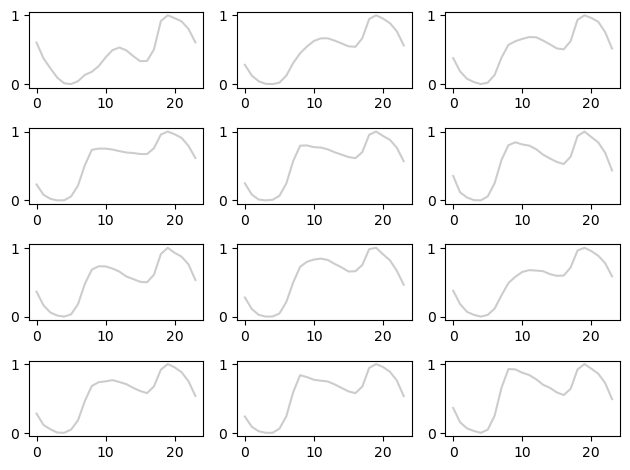

In [100]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X[yi].ravel(), "k-", alpha=.2)

plt.tight_layout()

In [102]:
Sum_of_squared_distances = []
K = range(2,12)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

In [104]:
Sum_of_squared_distances

[0.0454216330279861,
 0.03845276155352934,
 0.03410907250183037,
 0.03282901262927206,
 0.029979405257626737,
 0.028249191857603977,
 0.02589529566115209,
 0.02525701347134747,
 0.02433630155289291,
 0.023376785003611972]

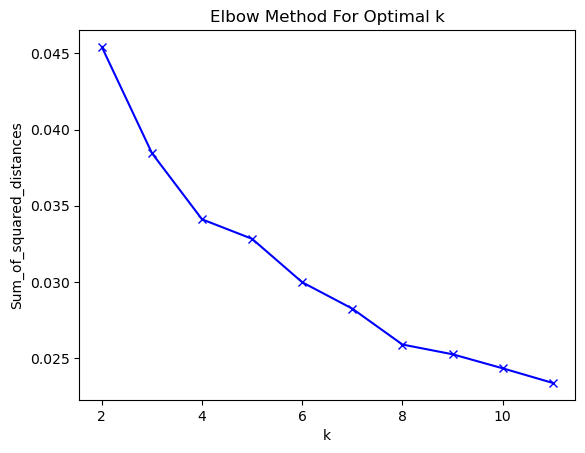

In [106]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Entrainement du modèle

Euclidean k-means
Euclidean silhoutte: 0.36


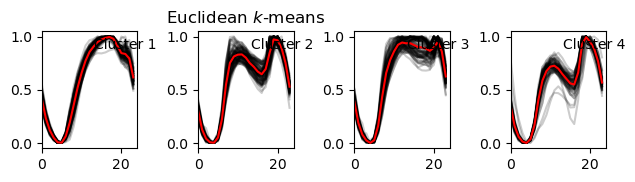

In [119]:
n_clusters = 4
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()
plt.show()

### Entrainement du modèle en utilisant DTW comme calcul de distance de dissimilarité

DBA k-means
DBA silhoutte: 0.23


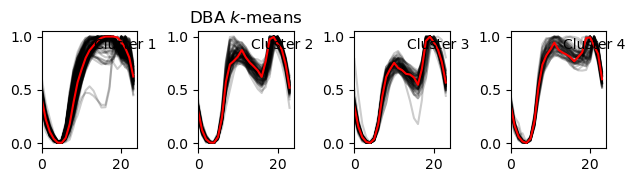

In [122]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in X[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()